1) Load in the dataset https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv into a pandas dataframe

In [1]:
import pandas as pd
import statsmodels.api as sm
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
import pylab
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
import re
import pylab as plt
import seaborn
from sklearn.linear_model import LinearRegression
import numpy.random as nprnd
pd.set_option('display.max_columns', 500)
%matplotlib inline
import random

df = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv', index_col=0)
df.head()

C:\Users\brian\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


2) Convert default and student to categorical variables.

In [31]:
df_default=pd.get_dummies(df['default'])
df_student=pd.get_dummies(df['student'])
df_final = pd.concat([df[['balance','income']],df_default, df_student],axis=1)
df_final.head()

,balance,income,No,Yes,No,Yes
1,729.526495,44361.625074,1,0,1,0
2,817.180407,12106.134700,1,0,0,1
3,1073.549164,31767.138947,1,0,1,0
4,529.250605,35704.493935,1,0,1,0
5,785.655883,38463.495879,1,0,1,0


In [2]:
cat_features=['default', 'student']
for c in cat_features:
    df[c] = df[c].astype('category')

df.head()
df.dtypes

default    category
student    category
balance     float64
income      float64
dtype: object

3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color of the outcome of default labeled red if yes and blue if no.

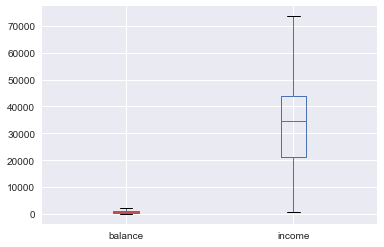

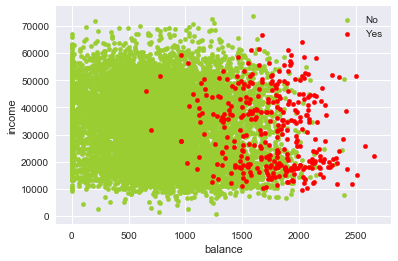

In [6]:
df.boxplot()
groups = df.groupby('default')
fig, ax = plt.subplots()
colors = {'Yes':'red', 'No':'yellowgreen'}
for key, group in groups:
    group.plot(ax=ax, kind='scatter', x='balance', y='income', label=key, color=colors[key])
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley on the balance and income variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

In [7]:
X=df[['balance', 'income']]
y=df[['default']]
size=len(df)

#clf = LogisticRegression()
#clf.fit(X, y.values.ravel())

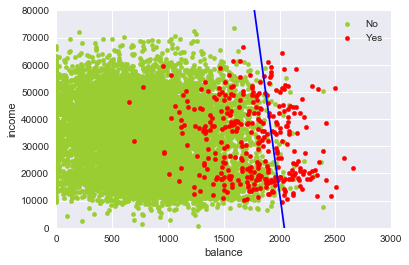

C:\Users\brian\Anaconda3\lib\site-packages\ipykernel\__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Area under the ROC curve : 0.960648


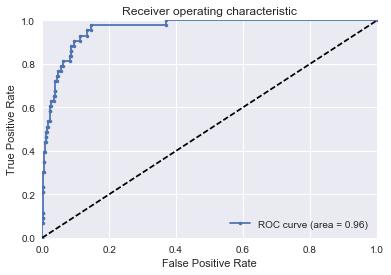

In [8]:
# plot points and Logistic Regression boundary
#x_min, x_max = X.ix[:, 0].min() - .5, X.ix[:, 0].max() + .5
#y_min, y_max = X.ix[:, 1].min() - .5, X.ix[:, 1].max() + .5
#xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
 #                    np.linspace(y_min, y_max, 50))
#plt.xlim(xx.min(), xx.max())
#plt.ylim(yy.min(), yy.max())

#ax = plt.gca()
#Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
#Z = Z.reshape(xx.shape)
#cs2 = ax.contour(xx, yy, Z, levels=[.5], cmap='RdBu', alpha=.5)
#plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14)
#for key, group in groups:
 #   group.plot(ax=ax, kind='scatter', x='balance', y='income', label=key, color=colors[key])
#plt.show()

from sklearn.multiclass import OneVsRestClassifier
clf=OneVsRestClassifier(LogisticRegression(penalty='l1')).fit(X,y)
coef=clf.coef_
intercept=clf.intercept_
ex1=np.linspace(0,3000,3000)
ex2=-(coef[:,0]*ex1+intercept[:,0])/coef[:,1]
ax=plt.subplot(111)
for key, group in groups:
    group.plot(ax=ax, kind='scatter', x='balance', y='income', label=key, color=colors[key])
ax.plot(ex1,ex2,c='blue',label='Decision Boundary') 
ax.set_xlim([0, 3000])
ax.set_ylim([0, 80000])
plt.show()

#convert y to binary data
y['default'] = y['default'].map({'Yes': 1, 'No': 0})

# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print("Area under the ROC curve : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y.values.ravel(),LogisticRegression,C=0.1,penalty='l1')

def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking of coefficients. How does performance improve with the added variable?

In [32]:
df_default=pd.get_dummies(df['default'])
df_student=pd.get_dummies(df['student'])
df_final = pd.concat([df[['balance','income']],df_default, df_student],axis=1)
df_final.head()

,balance,income,No,Yes,No,Yes
1,729.526495,44361.625074,1,0,1,0
2,817.180407,12106.134700,1,0,0,1
3,1073.549164,31767.138947,1,0,1,0
4,529.250605,35704.493935,1,0,1,0
5,785.655883,38463.495879,1,0,1,0


C:\Users\brian\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\brian\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\brian\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Area under the ROC curve : 0.959703
Area under the ROC curve : 0.960176
Area under the ROC curve : 0.960562
Area under the ROC curve : 0.960634
Area under the ROC curve : 0.960849
Area under the ROC curve : 0.961150
Area under the ROC curve : 0.961307
Area under the ROC curve : 0.961450
Area under the ROC curve : 0.961636
Area under the ROC curve : 0.961665
Area under the ROC curve : 0.961708
Area under the ROC curve : 0.961751
Area under the ROC curve : 0.961780
Area under the ROC curve : 0.961765
Area under the ROC curve : 0.961851
Area under the ROC curve : 0.961980
Area under the ROC curve : 0.961995
Area under the ROC curve : 0.962009
Area under the ROC curve : 0.962037
Area under the ROC curve : 0.962052
Area under the ROC curve : 0.962138
Area under the ROC curve : 0.962209
Area under the ROC curve : 0.962224
Area under the ROC curve : 0.962238
Area under the ROC curve : 0.962295
Area under the ROC curve : 0.962238
Area under the ROC curve : 0.962224
Area under the ROC curve : 0

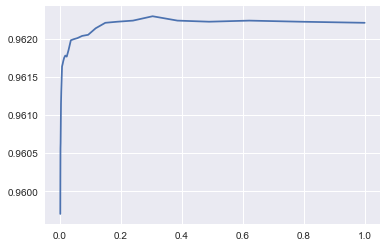

Optimal alpha : 0.303919538231


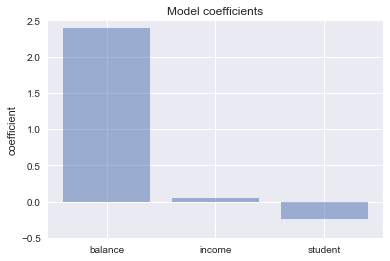

In [10]:
#make categorial variables into binary
X=df[['balance', 'income', 'student']]
X['student'] = X['student'].map({'Yes': 1, 'No': 0})
scaler = StandardScaler()
X = scaler.fit_transform(X)
y=df[['default']]
y['default'] = y['default'].map({'Yes': 1, 'No': 0})
size=len(df)

# Split the data into training/testing sets
X_train = X[0:int(size*0.8)]
X_test = X[int(size*0.8):]

# Split the targets into training/testing sets
y_train = y[0:int(size*0.8)]
y_test = y[int(size*0.8):]

alphas = np.logspace(-3,0,30)

scores = []

for alpha in alphas:
    regr = LogisticRegression(C=alpha,penalty='l2')

    # Train the model using the training sets
    regr.fit(X_train, y_train)
    fpr, tpr, roc_auc, thresholds= generate_auc(X,y,LogisticRegression,C=alpha,penalty='l2')
    scores.append(roc_auc)
plt.plot(alphas,scores)
plt.show()
i_alpha_optim = np.argmax(scores)
alpha_optim = alphas[i_alpha_optim]
print("Optimal alpha : %s" % alpha_optim)

coef =  LogisticRegression(C=alpha_optim,penalty='l2').fit(X,y).coef_

objects = ('balance', 'income', 'student')
y_pos = np.arange(len(objects))
#print(y_pos, coef[0])

plt.bar(y_pos, coef[0], align='center',alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylim([-0.5, 2.5])
plt.title('Model coefficients')

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

array([[-0.21883482,  0.81318727, -0.64593619],
       [-0.03761593, -1.60549572,  1.54814054],
       [ 0.49241019, -0.13121225, -0.64593619],
       ..., 
       [ 0.02075107,  1.88356527, -0.64593619],
       [ 1.51674204,  0.236363  , -0.64593619],
       [-1.31169066, -1.24880501,  1.54814054]])

In [110]:
from sklearn.model_selection import cross_val_score
regr = LogisticRegression(C=alpha,penalty='l2')
scores = cross_val_score(regr, X, y, cv=5)
plt.ylim([-1,1])
plt.xlabel('lambda')
plt.ylabel('R^2')
plt.title('Performance on 5 folds with lambda=' + str(alpha))
plt.bar(range(1,6),scores)
plt.show()

C:\Users\brian\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


IndexError: too many indices for array

In [32]:
X=X.astype(float)
np.isfinite(X).all()

True

In [33]:
# K-fold cross validation for model selection.
def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
   
    # Iterate through folds
    
    for train_index, test_index in kf:
        print(train_index.shape,test_index.shape)
        print(len(y),np.max(y), np.min(y))
        X_train, X_test = X[train_index], X[test_index]
        y_train = y.ix[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

y_pred=run_cv(X,y,LogisticRegression,C=alpha_optim,penalty='l2')
y_pred

(8000,) (2000,)
10000 default    1.0
dtype: float64 default    0.0
dtype: float64


C:\Users\brian\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

In [127]:
from sklearn.tree import DecisionTreeClassifier
X=df[['balance', 'income', 'student']]
X['student'] = X['student'].map({'Yes': 1, 'No': 0})
#scaler = StandardScaler()
#X = scaler.fit_transform(X)
y=df[['default']]
y['default'] = y['default'].map({'Yes': 1, 'No': 0})

# Split the data into training/testing sets
X_train = X[0:int(size*0.8)]
X_test = X[int(size*0.8):]

# Split the targets into training/testing sets
y_train = y[0:int(size*0.8)]
y_test = y[int(size*0.8):]

decTree = DecisionTreeClassifier(max_depth=5)
decTree.fit(X,y)
y_pred=decTree.predict(X_test)
y_pred

fpr, tpr, roc_auc, thresholds= generate_auc(X,y,DecisionTreeClassifier,max_depth=5)

#groups = df.groupby('default')
#fig, ax = plt.subplots()
#colors = {'Yes':'red', 'No':'blue'}
#for key, group in groups:
 #   group.plot(ax=ax, kind='scatter', x='balance', y='income', label=key, color=colors[key])

#plt.figure()
#plt.scatter(X['balance'], X['income'], c="blue", label="data")
#plt.plot(X_test, y_pred, color="yellowgreen", label="max_depth=5", linewidth=2)
#plt.xlabel("data")
#plt.ylabel("target")
#plt.title("Decision Tree Regression")
#plt.legend()
#plt.show()

C:\Users\brian\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\brian\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Area under the ROC curve : 0.932280


In [115]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [117]:
from __future__ import print_function

import os
import subprocess

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
#dt=DecisionTreeRegressor(max_depth=5)
visualize_tree(decTree, feature_names=['x'])

In [119]:
dot_data=export_graphviz(decTree, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

NameError: name 'pydotplus' is not defined

8) Find the optimal decision tree depth and compute the AUC ROC.

Area under the ROC curve : 0.932280


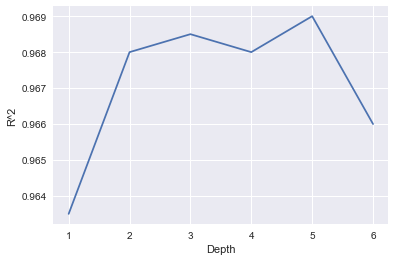

In [131]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
train_errors=[]
test_errors=[]
scores=[]
depths = range(1,7)
for n in depths:
    regr = DecisionTreeClassifier(max_depth=n)
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    train_errors.append(regr.score(X_train,y_train))
    scores.append(regr.score(X_test,y_test))
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.plot(depths,scores)
test_errors=scores
n_opt=depths[np.argmax(scores)]
fpr, tpr, roc_auc, thresholds= generate_auc(X,y,DecisionTreeClassifier,max_depth=5)

From the plot above, the optimal depth is 5. ROC at optimal depth of 5 is 0.932280.